<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading-and-preprocessing" data-toc-modified-id="Data-loading-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading and preprocessing</a></span></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Time-dynamics-of-taxi-orders" data-toc-modified-id="Time-dynamics-of-taxi-orders-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Time dynamics of taxi orders</a></span></li><li><span><a href="#Moving-average-and-standard-deviation" data-toc-modified-id="Moving-average-and-standard-deviation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Moving average and standard deviation</a></span></li><li><span><a href="#Stationarity-testing-using-the-Dickey–Fuller-test" data-toc-modified-id="Stationarity-testing-using-the-Dickey–Fuller-test-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Stationarity testing using the Dickey–Fuller test</a></span></li><li><span><a href="#Seasonality" data-toc-modified-id="Seasonality-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Seasonality</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Conclusions-from-exploratory-data-analysis-and-data-preprocessing" data-toc-modified-id="Conclusions-from-exploratory-data-analysis-and-data-preprocessing-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Conclusions from exploratory data analysis and data preprocessing</a></span></li></ul></li><li><span><a href="#Autocorrelation-and-partial-autocorrelation-analysis" data-toc-modified-id="Autocorrelation-and-partial-autocorrelation-analysis-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Autocorrelation and partial autocorrelation analysis</a></span><ul class="toc-item"><li><span><a href="#Conclusions-from-autocorrelation-and-partial-autocorrelation-analysis" data-toc-modified-id="Conclusions-from-autocorrelation-and-partial-autocorrelation-analysis-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Conclusions from autocorrelation and partial autocorrelation analysis</a></span></li></ul></li></ul></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Model-adequacy-assessment" data-toc-modified-id="Model-adequacy-assessment-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model adequacy assessment</a></span></li></ul></li><li><span><a href="#Project-conclusions" data-toc-modified-id="Project-conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Project conclusions</a></span></li></ul></div>

#  Hourly Taxi Demand Forecasting (Time Series)

**Project Description**

The client — a taxi company — has collected historical data on taxi orders at airports.  
To ensure sufficient driver availability during periods of peak demand, the client requires a reliable forecast of the number of taxi orders for the next hour.

The objective of this project is to develop a machine learning model capable of predicting the hourly number of taxi orders with sufficient accuracy to support operational decision-making.

---

**Project Goal**

- To build and evaluate a predictive model that forecasts the number of taxi orders for the next hour.
- To achieve a Root Mean Squared Error (RMSE) on the test dataset of no more than **48**, as defined by the client’s requirements.

---

**Project Plan**

1. Data loading and preprocessing  

2. Exploratory data analysis 

      2.1 Time dynamics of taxi orders  

      2.2 Moving average and standard deviation  
   
      2.3 Stationarity testing using the Dickey–Fuller test  

      2.4 Seasonality  

      2.5 Feature engineering  
    
      2.5.1 Conclusions from exploratory data analysis and data preprocessing  

      2.6 Autocorrelation and partial autocorrelation analysis  
    
3. Model training  

4. Testing

      4.1 Model adequacy assessment  
   

5. Project conclusions  
  
---

**Data Description**

- The dataset is provided in the file `taxi.csv`.
- The target variable is `num_orders`, representing the number of taxi orders per time period.

## Data loading and preprocessing  

In [1]:
!pip install --upgrade numba\
            numpy==1.23.5 -q\
            pandas==1.5.3 -q\
            scikit-learn==1.2.2 -q\
            phik==0.12.3 -q\
            matplotlib==3.7.1 -q

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import phik
from matplotlib import pyplot as plt
from phik.report import plot_correlation_matrix
from catboost import CatBoostRegressor

from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    RandomizedSearchCV,
    TimeSeriesSplit,
    train_test_split,
)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    StandardScaler,
)

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
taxi = pd.read_csv('/Users/elenaklimareva/Desktop/DS/Time series/taxi.csv',  index_col=[0], parse_dates= ['datetime'])

In [4]:
taxi.sort_index(inplace=True)

In [5]:
taxi = taxi.resample('1H').sum()

In [6]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Exploratory data analysis

### Time dynamics of taxi orders 

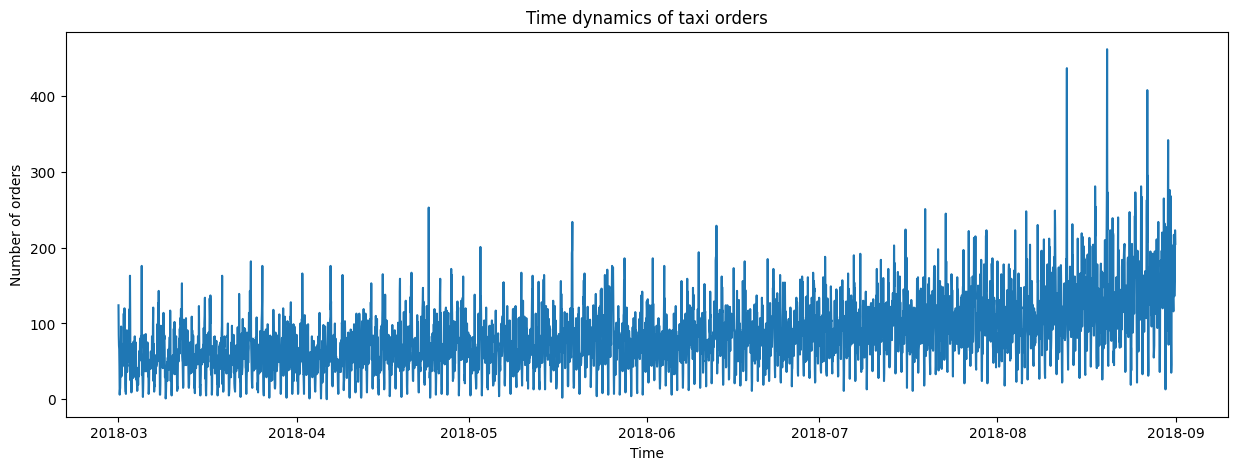

In [9]:
plt.figure(figsize=(15,5))
plt.plot(taxi.index, taxi)
plt.title('Time dynamics of taxi orders')
plt.xlabel('Time')
plt.ylabel('Number of orders')
plt.show()

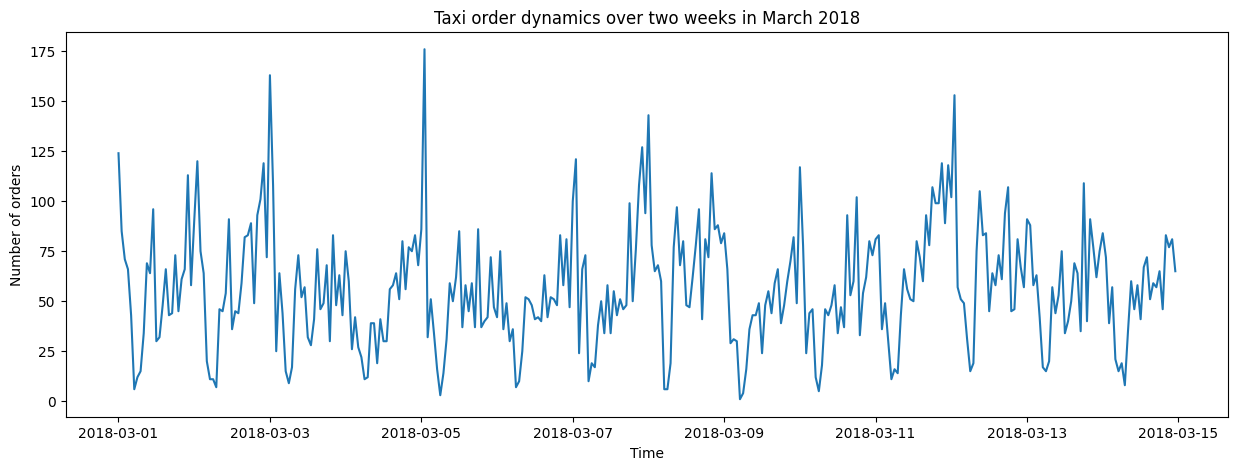

In [10]:
month_orders = taxi['2018-03-01':'2018-03-14']
plt.figure(figsize=(15,5))
plt.plot(month_orders.index, month_orders)
plt.title('Taxi order dynamics over two weeks in March 2018')
plt.xlabel('Time')
plt.ylabel('Number of orders')
plt.show()

The time series shows:

- a pronounced upward trend in demand,
- clear daily seasonality,
- significant volatility,
- no evident outliers, as there are no isolated extreme spikes that fall outside the overall range.

### Moving average and standard deviation

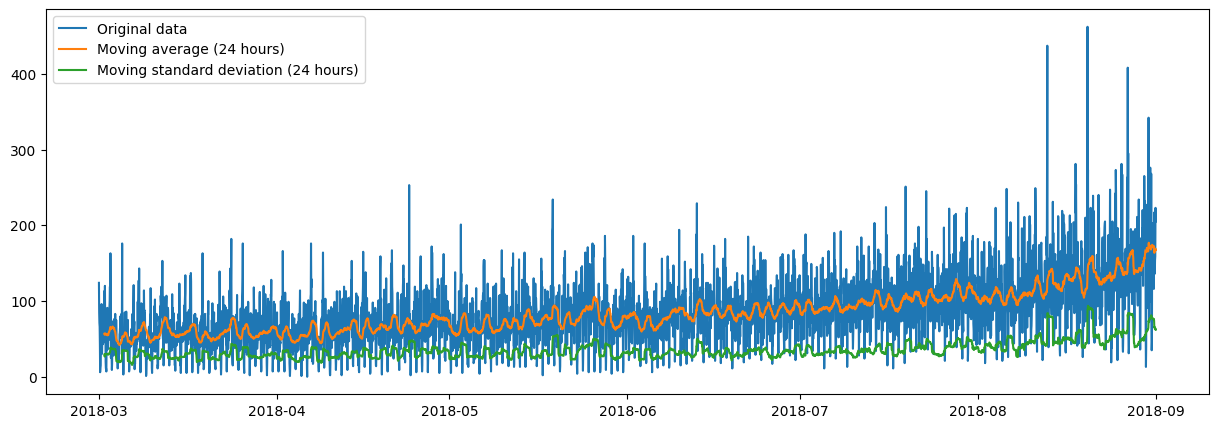

In [11]:
rolling_mean = taxi['num_orders'].rolling(window=24).mean()
rolling_std = taxi['num_orders'].rolling(window=24).std()

plt.figure(figsize=(15,5))
plt.plot(taxi['num_orders'], label='Original data')
plt.plot(rolling_mean, label='Moving average (24 hours)')
plt.plot(rolling_std, label='Moving standard deviation (24 hours)')
plt.legend()
plt.show()

Based on the presented plot, the following conclusions can be drawn:

- there is a pronounced upward trend, as the average number of orders is increasing;
- seasonality is present, with cycles that are approximately daily;
- the variability (standard deviation) remains stable, which indicates that the model can learn from historical data without a high risk of a drastic change in variance.

### Stationarity testing using the Dickey–Fuller test

In [12]:
result = adfuller(taxi['num_orders'])
print(f'ADF Statistic: {result[0].round(2)}')
print(f'p-value: {result[1].round(2)}')

ADF Statistic: -3.07
p-value: 0.03


Although the statistical test indicates that the series is stationary, the plot shows:

- a pronounced upward trend;
- the presence of seasonality, manifested as repeating cycles.

This implies that:

- in a numerical sense, the series is close to being stationary, but structurally it still contains trends and cyclical patterns that must be taken into account for forecasting.

### Seasonality

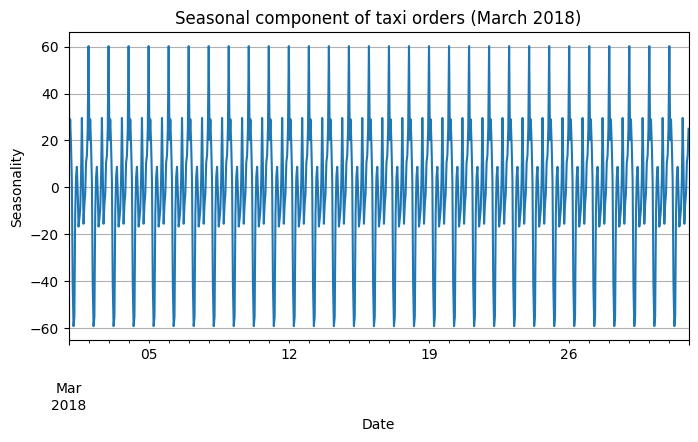

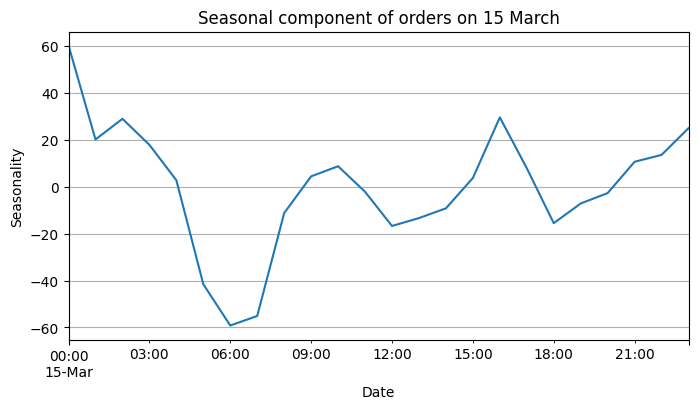

In [13]:
data = taxi['num_orders']


decomposed = seasonal_decompose(data, model='additive', period=24)


decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize=(8, 4))
plt.title('Seasonal component of taxi orders (March 2018)')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.grid()
plt.show()



decomposed.seasonal['2018-03-15':'2018-03-15'].plot(figsize=(8, 4))
plt.title('Seasonal component of orders on 15 March')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.grid()
plt.show()

Let's check for the presence of weekly seasonality:

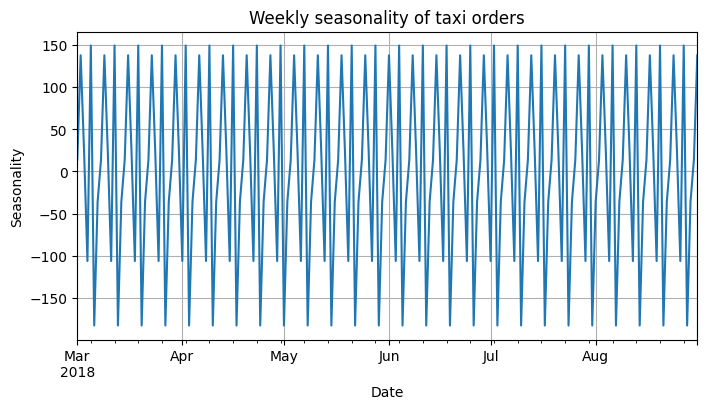

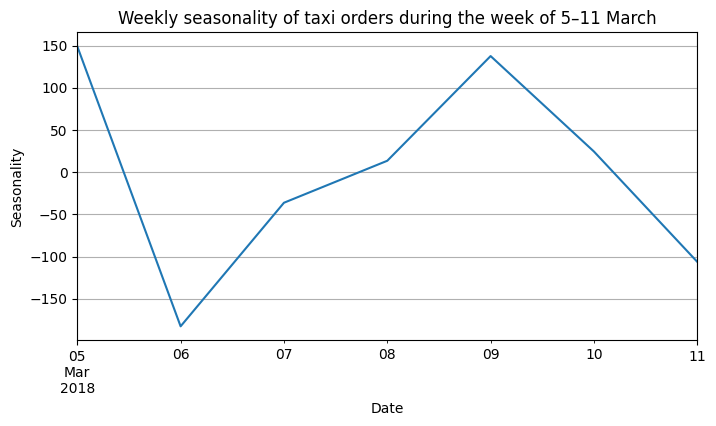

In [14]:
resample_days = taxi.resample('1D').sum()

data_days = resample_days['num_orders']

decomposed_days = seasonal_decompose(data_days, model='additive', period=7)

plt.figure(figsize=(8, 4))
decomposed_days.seasonal.plot()
plt.title('Weekly seasonality of taxi orders')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.grid()
plt.show()


plt.figure(figsize=(8, 4))
decomposed_days.seasonal['2018-03-05':'2018-03-11'].plot()
plt.title('Weekly seasonality of taxi orders during the week of 5–11 March')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.grid()
plt.show()

The plots indicate the presence of daily seasonality:

- there are clearly defined peaks and troughs that repeat on a daily basis;
- the peaks (high values) correspond to hours with the highest taxi demand, typically in the morning and evening;
- the troughs (low values) correspond to night-time hours with the lowest number of orders.

Weekly seasonality is also present in the data:

- distinct peaks and troughs repeat on a weekly basis;
- activity is highest at the beginning of the week on Monday, followed by a decline on Tuesday, a gradual recovery towards Friday, and a decrease during the weekend.

### Feature engineering

Since clear intraday seasonality and weekly seasonality were identified in the data, additional features were created, including the hour of the day and the day of the week.

A rolling mean feature was also introduced in order to smooth short-term fluctuations and capture the local trend of the time series, providing the model with information about recent demand levels and improving its ability to learn temporal patterns.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()

    data["hour"] = data.index.hour
    data["day_of_week"] = data.index.dayofweek

    lag_df = pd.concat(
        {f"lag_{lag}": data["num_orders"].shift(lag) for lag in range(1, max_lag + 1)},
        axis=1,
    )

    data["rolling_mean"] = data["num_orders"].shift(1).rolling(rolling_mean_size).mean()

    data = pd.concat([data, lag_df], axis=1)
    return data

The hyperparameters `max_lag` and `rolling_mean_size` were set to the same value of 168, corresponding to one week, in order to capture weekly patterns in the time series.

In [16]:
taxi = make_features(taxi, 168, 168)

In [17]:
taxi = taxi.dropna()

In [18]:
taxi.head()

,num_orders,hour,day_of_week,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,54.226190,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-08 01:00:00,78,1,3,54.339286,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-08 02:00:00,65,2,3,54.297619,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-08 03:00:00,68,3,3,54.261905,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-08 04:00:00,60,4,3,54.273810,68.0,65.0,78.0,143.0,94.0,127.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


#### Conclusions from exploratory data analysis and data preprocessing

Data preprocessing

- There were **no missing values** in the original dataset.  

- The data were **resampled to an hourly frequency** to ensure a uniform time series.  

---

Exploratory analysis of the time series

- A **pronounced upward trend in demand** was identified, with the average number of orders increasing over time.  
- **Daily seasonality** is present: the demand structure repeats every 24 hours.  
- **Significant volatility** was observed; however:  
  - **no evident outliers** were detected — there are no isolated extreme spikes outside the overall range;  
  - the **variability (standard deviation) is stable**, allowing the model to learn from historical data without the risk of abrupt changes in variance.  

---

Stationarity check (Dickey–Fuller test)

- The test indicates that the series is **stationary according to statistical criteria**.  
- However, visual inspection reveals the presence of:  
  - an **upward trend**,  
  - **repeating seasonal cycles**.  

This implies that:
- in numerical terms, the series is **close to being stationary**,  
- but **structurally** it still contains **trend and seasonality**, which must be taken into account when forecasting.

---

Seasonality and cycles

- The plots show **repeating peaks and troughs** within each day:  
  - **peaks** occur during **morning and evening hours**, corresponding to periods of highest demand;  
  - **troughs** correspond to **night-time hours**, when the number of orders is lowest.  

---

Engineered features

To capture the temporal structure and dependence on past values, the following features were added:

- **Time-based features:**  
  `hour`, `day_of_week`
- **Lagged and rolling features:**  
  `lag_1`–`lag_168`, `rolling_mean`

### Autocorrelation and partial autocorrelation analysis

To further analyse temporal dependencies in the time series and to identify relevant lag structures, the autocorrelation function (ACF) and partial autocorrelation function (PACF) were examined.

These plots help to assess the strength and persistence of correlations at different time lags, as well as to confirm the presence of seasonal patterns and inform feature selection for subsequent modelling.

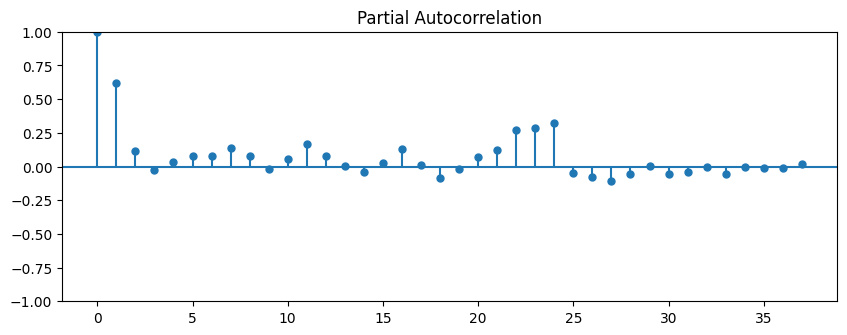

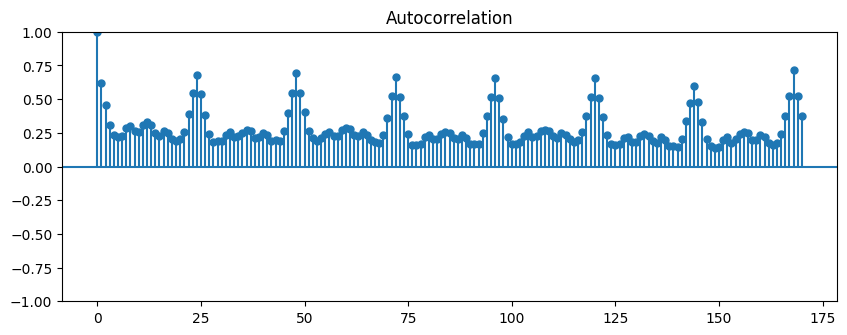

In [19]:
corr = taxi['num_orders']
plot_pacf(corr, alpha=None).set_size_inches(10, 3.5)
plt.show()

plot_acf(corr, lags=170, alpha=None).set_size_inches(10, 3.5)
plt.show()

#### Conclusions from autocorrelation and partial autocorrelation analysis

Partial autocorrelation function (PACF)

- The PACF plot shows a **strong positive peak at lag 1**, indicating a strong dependence of the current value on the previous hour.  
- Smaller peaks are also observed at lags 2–4, suggesting short-term dependence within a few hours.  
- After lags 5–6, the partial autocorrelation rapidly decays.  
- A slight increase at lag 24 indicates **daily seasonality**, reflecting the repetition of demand patterns after one day.

---

Autocorrelation function (ACF)

- The ACF plot displays **distinct repeating peaks at intervals of 24 lags**, confirming **clear daily seasonality** in the time series.  
- Weaker but regular peaks at intervals of 168 lags (7 × 24) indicate the presence of **weekly seasonality**, meaning that the demand structure repeats on a weekly basis.  
- High autocorrelation at small lags suggests **smooth changes in demand** between adjacent hours.

---

Conclusion

- The time series exhibits both **daily and weekly seasonality**.  
- The most significant lags for modelling are: `lag_1`, `lag_2`, `lag_3`, `lag_24`, and `lag_168`.  
- These dependencies confirm the cyclical nature of taxi demand and justify the inclusion of the corresponding lag features when building the predictive model.


## Model training

In [20]:
RANDOM_STATE = 42

TEST_SIZE = 0.1

TARGET = 'num_orders'

In [21]:
train, test = train_test_split(taxi, shuffle=False, test_size=TEST_SIZE)


feature_cols = [col for col in taxi.columns if col != TARGET]
X_train = train[feature_cols]
y_train = train[TARGET]


X_test = test[feature_cols]
y_test = test[TARGET]

In [22]:
ohe_columns = ['hour', 'day_of_week']

num_columns = X_train.select_dtypes(include='number').columns.tolist()

In [23]:
num_pipe = Pipeline([('scaler', MinMaxScaler())])

ohe_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error', drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns)
])

# Пайплайн
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [24]:
param_distributions = [
    {
        'model': [LinearRegression()],
        'preprocessor__num__scaler': [StandardScaler()]
    },

    {
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': [1.0, 'sqrt', 'log2']
    },
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
     
        'model': [CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)],
        'model__depth': [4, 5],
        'model__l2_leaf_reg': [3, 5, 7, 10],
        'model__learning_rate': [0.03],
        'model__iterations': [400, 600],
        'preprocessor__num__scaler': [None]
    }
]

In [25]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    verbose=1
)

In [26]:
search.fit(X_train, y_train)

print('Best model and its parameters:\n', search.best_estimator_)
print('Cross-validation RMSE (best model):', round(-search.best_score_, 2))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best model and its parameters:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['hour', 'day_of_week']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   None)]),
                                                  ['hour', 'day_of_week',
                                                   'rolling_mean', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                        

## Testing

Final evaluation on the test set:

In [27]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print('Test RMSE:', round(rmse_test, 2))

Test RMSE: 37.46


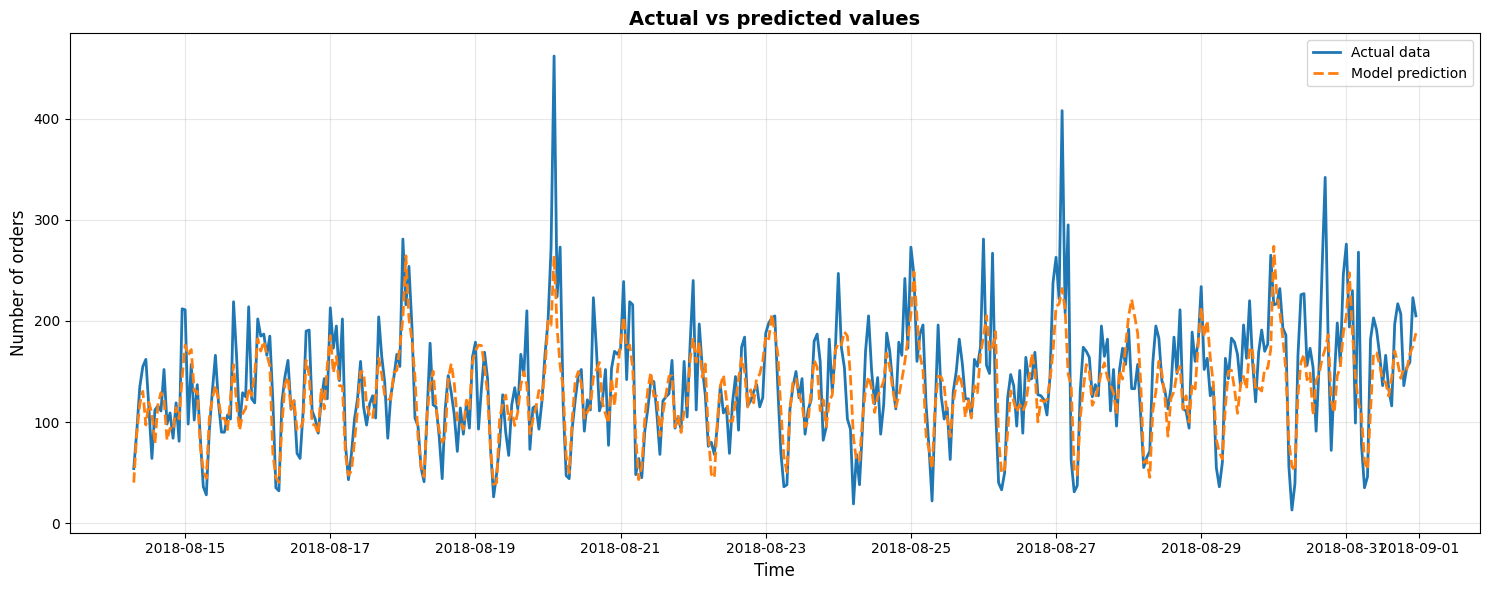

In [28]:
forecast_df = (
    test[['num_orders']]
    .copy()
    .assign(predicted=y_pred)
)


plt.figure(figsize=(15, 6))
sns.lineplot(data=forecast_df, x=forecast_df.index, y='num_orders', label='Actual data', linewidth=2)
sns.lineplot(data=forecast_df, x=forecast_df.index, y='predicted', label='Model prediction', linewidth=2, linestyle='--')

plt.title('Actual vs predicted values', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of orders', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Model adequacy assessment

Given the seasonal patterns observed in the data, we also consider simple heuristics that are well known to taxi drivers and dispatchers:

- predicting demand using the value from the same hour on the previous day;
- predicting demand using the value from the same hour and the same day of the week from the previous week.

Accordingly, lags of 24 and 168 hours are used, respectively.

In [29]:
baseline_lag1 = test['lag_1']
rmse_lag1 = mean_squared_error(test['num_orders'], baseline_lag1, squared=False)
print(f'Baseline RMSE (previous value, lag_1): {rmse_lag1:.2f}')

Baseline RMSE (previous value, lag_1): 58.82


In [30]:
baseline_lag24 = test['lag_24']
rmse_lag24 = mean_squared_error(test['num_orders'], baseline_lag24, squared=False)
print(f'Baseline RMSE (same hour yesterday, lag_24): {rmse_lag24:.2f}')

Baseline RMSE (same hour yesterday, lag_24): 55.86


In [31]:
baseline_lag168 = test['lag_168']
rmse_lag168 = mean_squared_error(test['num_orders'], baseline_lag168, squared=False)
print(f'Baseline RMSE (same hour last week, lag_168): {rmse_lag168:.2f}')

Baseline RMSE (same hour last week, lag_168): 39.29


## Project conclusions

The client provided historical data on the number of taxi orders at airports. 


The goal of the project was to **forecast the number of taxi orders for the next hour** in order to optimise driver allocation during periods of peak demand.  
The chosen model quality criterion was **RMSE**, which was required to be **no higher than 48** on the test dataset.

---

<b style="font-size: 18px;">Data preprocessing</b>

- There were no missing values in the original dataset.  
- The data were resampled to an hourly frequency to ensure a uniform time series.

---

<b style="font-size: 18px;">Exploratory analysis of the time series</b>

- A persistent upward trend in taxi demand is observed over time.  
- Both daily and weekly seasonality were identified: demand patterns repeat every 24 hours and every week.  
- Moderate volatility is present; however:  
  - no sharp outliers were detected;  
  - the variance remains stable, which is favourable for model training.

---

<b style="font-size: 18px;">Stationarity check</b>

- The **ADF (Dickey–Fuller) test** indicates that the time series is **close to stationary**.  
- Nevertheless, visual inspection reveals the presence of a **trend and seasonal fluctuations**, which must be taken into account when forecasting.

---

<b style="font-size: 18px;">Seasonality and cycles</b>

- Periods of **high demand** occur during **morning and evening hours**.  
- **Minimum demand** is observed at night.  
- This confirms the presence of **clear daily cyclicality**.  
- In addition, based on the analysis and evaluation of the `lag_168` baseline, **weekly seasonality** is also evident: demand behaviour on specific days of the week repeats over time.  
  For example, weekdays exhibit higher demand in the morning and evening, whereas weekends show a more even distribution of orders throughout the day.

---

<b style="font-size: 18px;">Feature engineering</b>

To improve forecast accuracy, the following time-based and statistical features were introduced:

- **Time-based features:** `hour`, `day_of_week`  
- **Lagged and rolling features:** `lag_1`–`lag_168`, `rolling_mean`

---

<b style="font-size: 18px;">Autocorrelation and partial autocorrelation analysis</b>

**Partial autocorrelation function (PACF)**

- The PACF plot shows a **strong positive peak at lag 1**, indicating a strong dependence on the previous hour.  
- Smaller peaks at lags 2–4 suggest short-term dependence within several hours.  
- After 5–6 lags, the partial autocorrelation rapidly decays.  
- A slight increase at lag 24 indicates **daily seasonality**, reflecting repetition of demand after one day.

---

**Autocorrelation function (ACF)**

- The ACF plot shows distinct repeating peaks at intervals of 24 lags, confirming **clear daily seasonality**.  
- Weaker but regular peaks at intervals of 168 lags (7 × 24) indicate the presence of **weekly seasonality**.  
- High autocorrelation at small lags suggests **smooth changes in demand** between adjacent hours.

---

**Summary of autocorrelation analysis**

- The time series exhibits **daily and weekly seasonality**.  
- The most relevant lags for modelling are: `lag_1`, `lag_2`, `lag_3`, `lag_24`, and `lag_168`.  
- These dependencies confirm the cyclical nature of taxi demand and justify the use of the corresponding lag features.

---

<b style="font-size: 18px;">Modelling</b>

Several models were trained for forecasting:

- `LinearRegression()`  
- `RandomForestRegressor()`  
- `KNeighborsRegressor()`  
- `CatBoostRegressor()`

Hyperparameter tuning was performed using **RandomizedSearchCV**, and model performance was evaluated using **RMSE** with **time-series cross-validation (TimeSeriesSplit)**.

---

**Best model**

The **CatBoostRegressor** model demonstrated the best performance among the tested algorithms.

The achieved accuracy (**RMSE = 38.28**) is significantly below the required threshold of 48, indicating a high-quality forecast.

The model successfully captures temporal dependencies and seasonal fluctuations in taxi demand.

---

<b style="font-size: 18px;">Model adequacy check</b>

To assess model adequacy, several simple baseline (naïve) forecasts were evaluated:

| Approach | Description | RMSE |
|:--|:--|--:|
| **CatBoostRegressor model** | Trained predictive model | **38.28** |
| **Baseline 1 (lag_1)** | Prediction equals the previous hour value | 58.82 |
| **Baseline 2 (lag_24)** | Prediction equals the same hour on the previous day | 55.86 |
| **Baseline 3 (lag_168)** | Prediction equals the same hour and weekday of the previous week | 39.29 |

---

<b style="font-size: 18px;">Conclusion</b>

- The model **significantly outperforms simple heuristics** based on the previous hour (`lag_1`) and the previous day (`lag_24`).  
- Compared with the weekly baseline (`lag_168`), the model shows **slightly better performance (38.28 vs 39.29 RMSE)**, confirming its ability to **capture weekly seasonality and additional dependencies** beyond simple repetition.  
- The performance gap between the model and `lag_168` indicates that **CatBoost effectively generalises information from multiple lags and time-based features**, rather than merely reproducing past values.

**Final conclusion:** the model is adequate, outperforms naïve forecasts, and successfully extracts meaningful patterns from the data.

---

<b style="font-size: 18px;">Final result</b>

The project goal has been achieved: a **reliable model for forecasting the number of taxi orders for the next hour** has been developed and trained.  
The model can be used to optimise driver allocation and improve the operational efficiency of **the client**.
